In [3]:
import numpy as np
import sys
import awkward as ak
import uproot as ur
import matplotlib.pyplot as plt
from numpy import genfromtxt
import math
import matplotlib as mpl
import vector
from tqdm import tqdm

sys.path.append('/home/mjovanovic/Work/LCStudies')
sys.path.append('/home/mjovanovic/Work/PointNet_Segmentation/')
from utils.particle_data_visualize_plot_utils import *
from utils.track_metadata import *
from utils.data_processing_util import *


ModuleNotFoundError: No module named 'utils'

<b>Define dataset to be loaded </b> </br>
These files contain all dataset features ie. cell eta, sampling layer, track phi, etc. this is saved separately from the class labels and preds

In [24]:
# DEFINE DATASET
delta_dir = "/fast_scratch_1/jbohm/cell_particle_deposit_learning/delta/delta_processed_test_files/" # base directory for all delta files
files_name = "delta_full"

# select subset of delta events to load
#   one track => p_pi0 = True and n_pipm = True
#   two tracks => p_pipm = True
include_delta_p_pi0 = True
include_delta_n_pi0 = False
include_delta_p_pipm = False
include_delta_n_pipm = True

# TODO: probably update to a bool
niche_case = "1_track_1_n_3_pi0" # only one niche case available 1_track_1_n_3_pi0, otherwise set to anything else ie. "None"

len_file = 6000

# select number of files to load (often 5 test files 0-4)
i_low = 0
i_high = 4
BATCH_SIZE = 100 # 80 for two files, 100 for other tests

LOG_ENERGY_MEAN = -1 # unrounded mean is ~ -0.93, used to normalize the log energy
LOG_MEAN_TRACK_MOMETUM = 2

<b>Define predictions data to be loaded </b>

In [112]:
# LOAD PREDICTIONS
epoch = 99
model_file_path =  "/fast_scratch_1/jbohm/cell_particle_deposit_learning/delta_train/tr_100_val_10_tst_5_delta_1_track_1_n_3_pi0_lr_1e-2_BS_100_no_tnets_add_min_dist"

labels_unmasked = ak.Array(np.load(model_file_path + "/tests/labels.npy"))
preds_unmasked = ak.Array(np.load(model_file_path + "/tests/preds_" + str(epoch) + ".npy"))

labels = labels_unmasked[labels_unmasked[:,:,0] != -1]
preds = preds_unmasked[labels_unmasked[:,:,0] != -1]

<b>Define predictions data to be loaded </b> </br>
A script similar to process_root_to_train_data.py when preprocessed = True </br>
(Details in /PointNet_Segmentation/python_scripts/data_processing/particle_deposit_learning/README.md)

In [47]:
# LOAD DATASET FROM PREPROCESSED TEST DATA FILES
dataset = "delta"
file_names = list(map(lambda i:  delta_dir + files_name + "_len_" + str(len_file) + "_i_" + str(i) + ".npy", np.arange(i_low, i_high + 1)))

max_num_tracks = 1 if dataset == "rho" else 2 # just delta and rho dataset processing for now

# load cell geo tree dict
file = ur.open("/data/atlas/data/rho_delta/rho_small.root")
cell_geo_tree = file["CellGeo"]

node_feature_names = cell_geo_tree.keys()[1:7] # 'cell_geo_sampling', 'cell_geo_eta', 'cell_geo_phi', 'cell_geo_rPerp', 'cell_geo_deta', 'cell_geo_dphi'


cell_geo_data = cell_geo_tree.arrays(library='np')
cell_geo_ID = cell_geo_data['cell_geo_ID'][0]
sorter = np.argsort(cell_geo_ID)

# cluster data dict to look up data by feature name
processed_event_data = {}
processed_event_track_data = {}
processed_event_track_flags = []

cell_geo_ID = cell_geo_data['cell_geo_ID'][0]

samples_count = 0
max_cells = 0
num_cells = 0

for feature in [*node_feature_names, "cell_eta", "trackP", "trackEta", "trackPhi", "truthPartE", "truthPartPt", "truthPartEta", "truthPartPhi", 'x', 'y', 'z', 'cell_hitsTruthIndex', 'cell_hitsTruthE', 'frac_pi0_energy', 'class_frac_pi0_energy', 'cell_E', 'cell_E_weight', 'sampling_layer', 'truthPartPt', 'truthPartEta', 'truthPartPhi', 'clus_idx', 'clus_em_prob', 'decay_group', 'cell_labels', 'cell_part_deposit_labels', "E_frac_focused", "cell_weights"]:#, 'delta_R']:
    processed_event_data[feature] = []

for feature in ['x', 'y', 'z', 'P', 'min_dist', 'min_eta', 'min_phi', 'sampling_layer', 'track_eta', 'track_phi', 'non_null_tracks', 'track_classes']:
    processed_event_track_data[feature] = []

cell_geo_ID = cell_geo_data['cell_geo_ID'][0]


for file_i, preprocessed_file_name in enumerate(file_names):
    events_arr = np.load(preprocessed_file_name, allow_pickle=True).item()
    
    num_events_saved = 0
    max_cells = 0
    num_cells = 0

    num_events = len(events_arr["eventNumber"])
    event_data = events_arr

    delta_n_pipm_count = 0
    
    print("LOAD FILE:", file_i, "/", len(file_names))
    for event_idx in tqdm(range(num_events)):
        num_tracks = event_data["nTrack"][event_idx]

        if (len(event_data["cluster_cell_ID"][event_idx]) and \
        (dataset == "delta" and 
            (((num_tracks == 1) and (\
                (include_delta_p_pi0 and event_data["decay_group"][event_idx] == decay_group["delta+_p"]) \
                or (include_delta_n_pipm and (event_data["decay_group"][event_idx] == decay_group["delta+_n"] or event_data["decay_group"][event_idx] == decay_group["delta-"])))) or \
            ((num_tracks == 0) and include_delta_n_pi0 and event_data["decay_group"][event_idx] == decay_group["delta0_n"]) or \
            ( (num_tracks == 2) and include_delta_p_pipm and (event_data["decay_group"][event_idx] == decay_group["delta0_p"] or event_data["decay_group"][event_idx] == decay_group["delta++"])))) \
        or (dataset == "rho" and num_tracks == 1)):


            # if case where 1_track_1_n_3_pi0 need to discard 5 delta->neutron+pipm events for every 1 kept
            if niche_case == "1_track_1_n_3_pi0" and (event_data["decay_group"][event_idx] == decay_group["delta+_n"] or event_data["decay_group"][event_idx] == decay_group["delta-"]):
                if delta_n_pipm_count == 0:
                    delta_n_pipm_count += 1

                else:
                    delta_n_pipm_count = (delta_n_pipm_count + 1) % 6
                    continue # don't save event when delta_n_pipm_count = 1, 2, 3, 4, 5
            
            if num_tracks > 0:
                x_tracks = []
                y_tracks = []
                z_tracks = []
                eta_tracks = []
                phi_tracks = []
                rPerp_track = []
                non_null_tracks = []
                for track_idx in range(num_tracks):
                    x_tracks.append([])
                    y_tracks.append([])
                    z_tracks.append([])
                    eta_tracks.append([])
                    phi_tracks.append([])
                    rPerp_track.append([])
                    non_null_tracks.append([])
                    # get the eta, phi, and rPerp of each layers hit
                    for layer_name in calo_layers:
                        if has_fixed_r[layer_name]:
                            eta_tracks[track_idx].append(event_data['trackEta_' + layer_name][event_idx][track_idx])
                            phi_tracks[track_idx].append(event_data['trackPhi_' + layer_name][event_idx][track_idx])
                            rPerp_track[track_idx].append(fixed_r[layer_name])
                        else:
                            eta = event_data['trackEta_' + layer_name][event_idx][track_idx]
                            eta_tracks[track_idx].append(eta)
                            phi_tracks[track_idx].append(event_data['trackPhi_' + layer_name][event_idx][track_idx])
                            
                            z = fixed_z[layer_name]
                            aeta = np.abs(eta)
                            rPerp = z*2*np.exp(aeta)/(np.exp(2*aeta) - 1)
                            rPerp_track[track_idx].append(rPerp)
                    
                    # convert each hit to the cartesian coords
                    thetas = [2*np.arctan(np.exp(-eta)) for eta in eta_tracks[track_idx]]
                    x_tracks_i, y_tracks_i, z_tracks_i = spherical_to_cartesian(rPerp_track[track_idx], phi_tracks[track_idx], thetas)
                    x_tracks[track_idx] = x_tracks_i
                    y_tracks[track_idx] = y_tracks_i
                    z_tracks[track_idx] = z_tracks_i

                    non_null_tracks_i = np.full(NUM_TRACK_POINTS, True)

                    # if eta > 4.9 or phi > pi mark the track as null (why??)
                    non_null_tracks_i[(np.abs(eta_tracks[track_idx]) >= 2.5) | (np.abs(phi_tracks[track_idx]) > np.pi)] = False

                    non_null_tracks[track_idx] = non_null_tracks_i

                if dataset == "delta":
                    if len(non_null_tracks) != 2:
                        non_null_tracks = np.concatenate((non_null_tracks, np.full((1, NUM_TRACK_POINTS), False)))
                        x_tracks = np.concatenate((x_tracks, np.full((1, NUM_TRACK_POINTS), False)))
                        y_tracks = np.concatenate((y_tracks, np.full((1, NUM_TRACK_POINTS), False)))
                        z_tracks = np.concatenate((z_tracks, np.full((1, NUM_TRACK_POINTS), False)))
            else:
                non_null_tracks = np.full((max_num_tracks, NUM_TRACK_POINTS), False)
                x_tracks, y_tracks, z_tracks = np.zeros((max_num_tracks, NUM_TRACK_POINTS)), np.zeros((max_num_tracks, NUM_TRACK_POINTS)), np.zeros((max_num_tracks, NUM_TRACK_POINTS))
            

            cell_IDs = event_data['cluster_cell_ID'][event_idx]
            cell_IDs = cell_IDs
            cell_ID_map = sorter[np.searchsorted(cell_geo_ID, cell_IDs, sorter=sorter)]

            # get cluster cell energy
            cell_E = event_data["cluster_cell_E"][event_idx]
        
            cell_weights = cell_E / np.sum(cell_E)

            # node features
            node_features = {}
            for feature in node_feature_names:
                node_features[feature] = cell_geo_data[feature][0][cell_ID_map]

            # get cartesian coords
            thetas = [2*np.arctan(np.exp(-eta)) for eta in node_features["cell_geo_eta"]]
            x, y, z = spherical_to_cartesian(node_features["cell_geo_rPerp"], node_features["cell_geo_phi"], thetas)

            # label cells (4 classes)
            # all decay groups only have 2 types particles depositing energy, a proton/neutron and a pion
            if dataset == "delta":
                class_part_idx_1 = 0
                class_part_idx_not_1 = 0

                if event_data["decay_group"][event_idx] == decay_group["delta+_p"]:
                    class_part_idx_1 = part_deposit_type_class["track_of_interest"] # proton
                    class_part_idx_not_1 = part_deposit_type_class["pi0"] # pi0
                elif event_data["decay_group"][event_idx] == decay_group["delta+_n"] or event_data["decay_group"][event_idx] == decay_group["delta-"]:
                    class_part_idx_1 = part_deposit_type_class["pi0"] # neutron # TODO: update this is temp
                    class_part_idx_not_1 = part_deposit_type_class["track_of_interest"] # pi+/-
                elif event_data["decay_group"][event_idx] == decay_group["delta0_n"]:
                    class_part_idx_1 = part_deposit_type_class["other_neutral"] # neutron
                    class_part_idx_not_1 = part_deposit_type_class["pi0"] # pi0
                # if decay is delta++ or delta0_p then set labels elsewhere (since 2 tracks)

                # get all cells with particle idx 1 (proton/neutron)
                cut_part_idx_1_deposits = (ak.Array(event_data["cluster_cell_hitsTruthIndex"][event_idx]) == 1)
                # get fraction of energy from the proton/neutron (always p/n in a rho event - it deposits some energy and the pion deposits the remaining)
                frac_cell_energy_from_part_idx_1 = ak.sum(ak.Array(event_data["cluster_cell_hitsTruthE"][event_idx])[cut_part_idx_1_deposits], axis=1) / ak.sum(event_data["cluster_cell_hitsTruthE"][event_idx], axis=1)
                # if frac_cell_energy_from_part_idx_1 < 0.5 set label class_part_idx_not_1 else set cell label to class_part_idx_1
                cell_part_deposit_labels = [class_part_idx_not_1 if cell_frac_cell_energy_from_part_idx_1 < 0.5 else class_part_idx_1 for cell_frac_cell_energy_from_part_idx_1 in frac_cell_energy_from_part_idx_1]
            # only pi0 and pi+/- depositing energy -> binary classification
            elif dataset == "rho":
                # if the pi0 deposits the majority of the energy label cell 1 else if pi+/- deposits majority label cell 0
                frac_pi0_energy = ak.sum(event_data["cluster_cell_hitsTruthE"][event_idx][event_data["cluster_cell_hitsTruthIndex"][event_idx] != 1], axis=1)/ak.sum(event_data["cluster_cell_hitsTruthE"][event_idx], axis=1)
                cell_part_deposit_labels = [1 if cell_frac_pi0_energy > 0.5 else 0 for cell_frac_pi0_energy in frac_pi0_energy]


            # if the particle has 2 tracks match the track to the particle closest & threshold that they must be close enough together
            # for delta dataset either delta++ -> proton + pi+/- or delta0 -> proton + pi+/-
            track_part_dist_thresh = 1
            if num_tracks == 2:

                part1_idx = 1 # proton
                part2_idx = 2 # charged pion

                part1_phi = event_data["truthPartPhi"][event_idx][part1_idx]
                part1_eta = event_data["truthPartEta"][event_idx][part1_idx]
                part1_pt = event_data["truthPartPt"][event_idx][part1_idx]

                part2_phi = event_data["truthPartPhi"][event_idx][part2_idx]
                part2_eta = event_data["truthPartEta"][event_idx][part2_idx]
                part2_pt = event_data["truthPartPt"][event_idx][part2_idx]

                track1_phi = event_data["trackPhi"][event_idx][0]
                track1_eta = event_data["trackEta"][event_idx][0]
                track1_pt = event_data["trackPt"][event_idx][0]

                track2_phi = event_data["trackPhi"][event_idx][1]
                track2_eta = event_data["trackEta"][event_idx][1]
                track2_pt = event_data["trackPt"][event_idx][1]

                part1_track1_dist = measure_track_part_dists(track1_phi, track1_eta, track1_pt, part1_phi, part1_eta, part1_pt)
                part1_track2_dist = measure_track_part_dists(track2_phi, track2_eta, track2_pt, part1_phi, part1_eta, part1_pt)
                part2_track1_dist = measure_track_part_dists(track1_phi, track1_eta, track1_pt, part2_phi, part2_eta, part2_pt)
                part2_track2_dist = measure_track_part_dists(track2_phi, track2_eta, track2_pt, part2_phi, part2_eta, part2_pt)

                # either pair part1 with track1 and part2 with track2 or part1 with track2 and part2 with track1
                # or discard event if no pairing exists with both track-part dists < thresh
                paring_one_sum_dist = part1_track1_dist + part2_track2_dist if part1_track1_dist < track_part_dist_thresh and part2_track2_dist < track_part_dist_thresh else 2*track_part_dist_thresh
                paring_two_sum_dist = part1_track2_dist + part2_track1_dist if part1_track1_dist < track_part_dist_thresh and part2_track2_dist < track_part_dist_thresh else 2*track_part_dist_thresh
                
                if max(paring_one_sum_dist, paring_two_sum_dist) >= 2*track_part_dist_thresh:
                    num_tracks = 0
                else:
                    if paring_one_sum_dist < paring_two_sum_dist:
                        pairing_one = True
                    else:
                        pairing_one = False

            track_idx = 0
            added_one_sample = False # for each event add one sample to dataset

            non_null_tracks = np.array(non_null_tracks)
            x_tracks = np.array(x_tracks)
            y_tracks = np.array(y_tracks)
            z_tracks = np.array(z_tracks)
            #non_null_tracks = np.array(flatten_one_layer(non_null_tracks))
            #x_tracks = np.array(flatten_one_layer(x_tracks))
            #y_tracks = np.array(flatten_one_layer(y_tracks))
            #z_tracks = np.array(flatten_one_layer(z_tracks))
            
            x_tracks[~non_null_tracks] = 0
            y_tracks[~non_null_tracks] = 0
            z_tracks[~non_null_tracks] = 0

            cell_has_E_deposit = ak.sum(event_data["cluster_cell_hitsTruthE"][event_idx], axis=1) > 0
            num_cells = len(cell_E[cell_has_E_deposit])
            
            # execute once for 0-1 track, and 2 times for 2 tracks
            while not added_one_sample or track_idx < num_tracks:
                processed_event_data["cell_E"].append(cell_E[cell_has_E_deposit])
                processed_event_data["x"].append(x[cell_has_E_deposit])
                processed_event_data["y"].append(y[cell_has_E_deposit])
                processed_event_data["z"].append(z[cell_has_E_deposit])
                processed_event_data["cell_weights"].append(cell_weights[cell_has_E_deposit])  

                # extra features for analysis
                processed_event_data["clus_idx"].append(ak.Array(event_data["clus_idx"][event_idx][cell_has_E_deposit]))
                processed_event_data["clus_em_prob"].append(ak.Array(event_data["clus_em_prob"][event_idx][cell_has_E_deposit]))
                processed_event_data["sampling_layer"].append(ak.Array(node_features["cell_geo_sampling"][cell_has_E_deposit]))
                processed_event_data["cell_hitsTruthIndex"].append(ak.Array(event_data["cluster_cell_hitsTruthIndex"][event_idx][cell_has_E_deposit]))
                processed_event_data["cell_hitsTruthE"].append(ak.Array(event_data["cluster_cell_hitsTruthE"][event_idx][cell_has_E_deposit]))
                processed_event_data["cell_eta"].append(node_features["cell_geo_eta"])

                processed_event_data["truthPartPt"].append(ak.Array(event_data["truthPartPt"][event_idx]))
                processed_event_data["truthPartE"].append(ak.Array(event_data["truthPartE"][event_idx]))
                processed_event_data["truthPartEta"].append(ak.Array(event_data["truthPartEta"][event_idx]))
                processed_event_data["truthPartPhi"].append(ak.Array(event_data["truthPartPhi"][event_idx]))  

                processed_event_data["trackPhi"].append(ak.Array(event_data["trackPhi"][event_idx]))  
                processed_event_data["trackEta"].append(ak.Array(event_data["trackEta"][event_idx]))  
                processed_event_data["trackP"].append(ak.Array(event_data["trackP"][event_idx]))  

                processed_event_data["decay_group"].append(event_data["decay_group"][event_idx])
                processed_event_data["E_frac_focused"].append(np.array(frac_cell_energy_from_part_idx_1)[cell_has_E_deposit])
                processed_event_data["cell_part_deposit_labels"].append(np.array(cell_part_deposit_labels)[cell_has_E_deposit])

                

                if dataset == "delta":
                    track_classes = np.zeros((2, NUM_TRACK_POINTS))
                    track_Ps = np.zeros((2, NUM_TRACK_POINTS))
                else:
                    track_classes = np.zeros((1, NUM_TRACK_POINTS))
                    track_Ps = np.zeros((1, NUM_TRACK_POINTS))
                        
                if num_tracks == 2:
                    # set track_idx to be the track of interest (for track idx 0 track 0 is of interest, else track 1)
                    if track_idx == 0:
                        track_classes[0] = np.ones(NUM_TRACK_POINTS)
                        track_classes[1] = np.full(NUM_TRACK_POINTS, 2)
                    else:
                        track_classes[1] = np.ones(NUM_TRACK_POINTS)
                        track_classes[0] = np.full(NUM_TRACK_POINTS, 2)

                    if (pairing_one and track_idx == 0) or (not pairing_one and track_idx == 1): # pair track 0 and part 1
                        class_part_idx_1 = 0 # track of interest
                        class_part_idx_not_1 = 1 # other tracked charged particle 

                    else: # pairing 1 and track idx == 1 or paring 2 and track idx == 0
                        class_part_idx_1 = 1
                        class_part_idx_not_1 = 0

                    cell_part_deposit_labels = [class_part_idx_not_1 if cell_frac_cell_energy_from_part_idx_1 < 0.5 else class_part_idx_1 for cell_frac_cell_energy_from_part_idx_1 in frac_cell_energy_from_part_idx_1]
                    #print("cell_labels:", cell_labels)
                    track_1_P =  np.log10((event_data["trackP"][event_idx][0])) - LOG_ENERGY_MEAN
                    track_2_P =  np.log10((event_data["trackP"][event_idx][1])) - LOG_ENERGY_MEAN
                    track_Ps[0] = np.full(NUM_TRACK_POINTS, track_1_P)
                    track_Ps[1] = np.full(NUM_TRACK_POINTS, track_2_P)
                
                elif num_tracks == 1:
                    # get tracks momentum readout
                    track_P = np.log10(event_data['trackP'][event_idx][0]) - LOG_MEAN_TRACK_MOMETUM
                    track_Ps[0] = np.full(NUM_TRACK_POINTS, track_P)
                    track_classes[0] = np.ones(NUM_TRACK_POINTS)

                #track_classes = np.array(flatten_one_layer(track_classes))
                #track_Ps = np.array(flatten_one_layer(track_Ps))

                track_classes[~non_null_tracks] = 0
                track_Ps[~non_null_tracks] = 0
                
                # else no tracks => Pt = 0


                processed_event_track_data["x"].append(x_tracks)
                processed_event_track_data["y"].append(y_tracks)
                processed_event_track_data["z"].append(z_tracks)
                processed_event_track_data["P"].append(track_Ps) # don't normalize for analysis

                # track classes - 0 => point, 1 => track of interest, 2 => other track
                processed_event_track_data["track_classes"].append(track_classes)
                
                if num_cells + NUM_TRACK_POINTS*max_num_tracks > max_cells:
                    max_cells = num_cells + NUM_TRACK_POINTS*max_num_tracks

                num_events_saved += 1
                added_one_sample = True
                track_idx += 1

    if BATCH_SIZE:
        # filter to BS multiple num samples/files - to make set even with preds from a trained model
        BS_multiple_num_samples = math.floor(num_events_saved / BATCH_SIZE)*BATCH_SIZE
        print("BS_multiple_num_samples", BS_multiple_num_samples)
        print("num_events_saved", num_events_saved)
        if BS_multiple_num_samples == num_events_saved:
            BS_multiple_num_samples -= BATCH_SIZE
        for key in processed_event_data:
            del processed_event_data[key][BS_multiple_num_samples - num_events_saved:]

        for key in processed_event_track_data:
            del processed_event_track_data[key][BS_multiple_num_samples - num_events_saved:]

        print("num dropped events:", num_events_saved - BS_multiple_num_samples)
        num_events_saved = BS_multiple_num_samples

LOAD FILE: 0 / 5


  0%|          | 0/5520 [00:00<?, ?it/s]/tmp/ipykernel_42666/1035891942.py:102: RuntimeWarning: overflow encountered in exp
  rPerp = z*2*np.exp(aeta)/(np.exp(2*aeta) - 1)
/tmp/ipykernel_42666/1035891942.py:102: RuntimeWarning: invalid value encountered in double_scalars
  rPerp = z*2*np.exp(aeta)/(np.exp(2*aeta) - 1)
/tmp/ipykernel_42666/1035891942.py:106: RuntimeWarning: overflow encountered in exp
  thetas = [2*np.arctan(np.exp(-eta)) for eta in eta_tracks[track_idx]]
100%|██████████| 5520/5520 [00:21<00:00, 252.82it/s]


BS_multiple_num_samples 800
num_events_saved 820
num dropped events: 20
LOAD FILE: 1 / 5


100%|██████████| 5568/5568 [00:20<00:00, 265.84it/s]


BS_multiple_num_samples 800
num_events_saved 866
num dropped events: 66
LOAD FILE: 2 / 5


100%|██████████| 5551/5551 [00:26<00:00, 208.74it/s]


BS_multiple_num_samples 800
num_events_saved 889
num dropped events: 89
LOAD FILE: 3 / 5


100%|██████████| 5556/5556 [00:20<00:00, 265.97it/s]


BS_multiple_num_samples 800
num_events_saved 841
num dropped events: 41
LOAD FILE: 4 / 5


100%|██████████| 5561/5561 [00:25<00:00, 221.23it/s]

BS_multiple_num_samples 800
num_events_saved 862
num dropped events: 62


Sanity check to ensure correct datasets were loaded

In [107]:
# CHECK PREDS VS DATA LOAD
# make sure they have the same num event to confirm the correct files/batch size/etc. were selected such that the loaded preds and labels are for the 
# same events as the loaded extra data features
print("num events (predictions)", len(preds_unmasked))
print("num events (loaded data):", len(processed_event_data["x"]))

num events (predictions) 4000
num events (loaded data): 4000


In [119]:
# ANALYSIS HELPER FUNCTIONS

def get_accuracy_multi_class(preds, labels):
    """
    Calculate accuracy for multi-class classification.

    Parameters:
    - preds (numpy.ndarray): Model predictions in one-hot encoded format.
    - labels (numpy.ndarray): True labels in one-hot encoded format.

    Returns:
    - float: Accuracy as a fraction (0 to 1).

    """

    # Check if the index of the maximum value (the predicted class) in predictions matches that in true labels
    correct = np.argmax(labels, axis=1) == np.argmax(preds, axis=1)
    # Calculate accuracy by counting correct predictions and dividing by the total number of predictions
    return np.count_nonzero(correct) / len(correct)


def plot_accuracy(model_file_path, num_epoch):
    """
    Plot accuracy over epochs. Prints plot to notebook, does not save.

    Parameters:
    - model_file_path (str): Path to the model.
    - num_epoch (int): Number of epoch to go up until.

    Returns:
    - None
    """
    labels_unmasked = ak.Array(np.load(model_file_path + "/tests/labels.npy"))
    labels = labels_unmasked[labels_unmasked[:,:,0] != -1]
    preds = []

    for epoch in range(num_epoch):
        preds_unmasked = ak.Array(np.load(model_file_path + "/tests/preds_" + str(epoch) + ".npy"))
        epoch_preds = preds_unmasked[labels_unmasked[:,:,0] != -1]
        preds.append(epoch_preds)

    accuracy = []
    for epoch_preds in preds:
        accuracy.append(get_accuracy_multi_class(epoch_preds, labels))

    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(accuracy, color="#009fdf")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy")
    plt.show()


def plot_loss(model_file_path, num_epoch=-1):
    """
    Plot training and validation loss on same axis.

    Parameters:
    - model_file_path (str): Path to the model files.
    - num_epoch (int): Number of epochs to plot up until.

    Returns:
    - None
    """
    loss_data = genfromtxt(model_file_path + "/log_loss.csv", delimiter=',').transpose()
    train_loss = loss_data[1][:num_epoch]
    val_loss = loss_data[2][:num_epoch]

    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(train_loss, label="train", color="#009fdf")
    plt.plot(val_loss, label="val", color="#F2705D")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss")
    plt.show()

def plot_frac_events_with_track_of_interest_vs_acc(preds_unmasked, labels_unmasked, part_of_interest, events_cut, bins):
    """
    Plot histogram and 2D distribution of accuracy vs. fraction of cells with a specific track class.

    Parameters:
    - preds_unmasked (numpy.ndarray): Model predictions before the padding is masked out.
    - labels_unmasked (numpy.ndarray): True labels without padding masked out.
    - part_of_interest (str): Particle of interest to include in title.
    - events_cut (numpy.ndarray): Mask of which events to keep based on a certain cut of particle decay selected.
    - bins (int): Number of bins.

    Returns:
    - None
    """
    track_of_interest_class = 0
    truth_frac_cells_part_of_interest_per_event = np.array([np.count_nonzero(event_decay_group == track_of_interest_class)/len(event_decay_group) for event_decay_group in processed_event_data["cell_part_deposit_labels"]] )
    pred_frac_cells_part_of_interest_per_event = np.array([np.count_nonzero(np.argmax(preds_unmasked[event_i], axis=1)[event_labels_unmasked[:,0] != -1] == track_of_interest_class)/np.count_nonzero(event_labels_unmasked[:,0] != -1) for event_i, event_labels_unmasked in enumerate(labels_unmasked)])
    
    plot_hist(truth_frac_cells_part_of_interest_per_event[events_cut], 200, "Truth classes in event", "Fraction of cells with " + part_of_interest + " class", "Frequency", True, colour="darkseagreen") 
    plot_hist(pred_frac_cells_part_of_interest_per_event[events_cut], 200, "Pred classes in event", "Fraction of cells with " + part_of_interest + " class", "Frequency", True, colour="darkseagreen")

    # plot 2d distribution vs accuracy
    event_mean_acc = np.array([get_accuracy_multi_class(preds_unmasked[event_i][event_labels_unmasked[:, 0] != -1], event_labels_unmasked[event_labels_unmasked[:, 0] != -1]) for event_i, event_labels_unmasked in enumerate(labels_unmasked)])

    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist2d(truth_frac_cells_part_of_interest_per_event[events_cut], event_mean_acc[events_cut], (bins, bins), range=((0,1),(0,1)), cmap=plt.cm.terrain_r, norm=mpl.colors.LogNorm())
    plt.colorbar(label="Frequency")
    plt.xlabel("Fraction of cells with " + part_of_interest + " class")
    plt.ylabel("Event accuracy")
    plt.title("All events")
    plt.show()



def plot_accuracy_over_cell_energy_frac_from_focused_part(preds_unmasked, labels_unmasked, cut, num_points, acc_func, focused_part):
    """
    Plot accuracy vs. fraction of cell energy from a focused part.

    Parameters:
    - preds_unmasked (numpy.ndarray): Model predictions before the padding is masked out.
    - labels_unmasked (numpy.ndarray): True labels without padding masked out.
    - cut (numpy.ndarray): Mask of which events to keep based on a certain cut of particle decay selected.
    - num_points (int): Number of points for the plot.
    - acc_func (function): Accuracy calculation function (ie. get_accuracy_multi_class).
    - focused_part (str): Focused particle to include in titles.

    Returns:
    - None
    """
    labels = labels_unmasked[cut][labels_unmasked[:,:,0][cut] != -1]
    preds = preds_unmasked[cut][labels_unmasked[:,:,0][cut] != -1]

    focused_frac = np.array(flatten_one_layer(np.array(processed_event_data["E_frac_focused"])[cut]))

    plot_hist(focused_frac, num_points, "Fraction of cell energy from " + focused_part, "Cell energy frac from " + focused_part, "Frequency", colour="#440154FF")

    accuracy = []

    for i in range(num_points):
        E_frac_cut = (focused_frac >= i*(1/num_points)) & (focused_frac < (i+1)*(1/num_points))
        accuracy.append(acc_func(preds[E_frac_cut], labels[E_frac_cut]))
    
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(np.arange(1/num_points, 1 + (1/num_points), 1/num_points), accuracy, color="#009fdf", linewidth=2.5)
    plt.axvline(x=0.5, color='grey', linewidth='0.5')
    plt.xlabel("Cell energy frac from " + focused_part)
    plt.ylabel("Accuracy")
    plt.title("Fraction of cell energy from " + focused_part + " vs classification accuracy")
    plt.xlim((-0.1, 1.1))
    plt.show()



def plot_accuracy_over_cut(preds_unmasked, labels_unmasked, event_cut_data, const_cut, num_points, title, xlabel, acc_func, xlim=None):
    """
    Plot accuracy over a certain cut. i. used to plot over different groups of delta R.

    Parameters:
    - preds_unmasked (numpy.ndarray): Model predictions.
    - labels_unmasked (numpy.ndarray): True labels.
    - event_cut_data (numpy.ndarray): Data for the cut.
    - const_cut (numpy.ndarray): Mask of which events to keep based on a certain cut of events selected.
    - num_points (int): Number of points for the plot.
    - title (str): Plot title.
    - xlabel (str): X-axis label.
    - acc_func (function): Accuracy calculation function (ie. get_accuracy_multi_class).
    - xlim (tuple): X-axis limits.

    Returns:
    - None
    """
    event_cut_data = np.array(event_cut_data)

    fig = plt.figure()
    fig.patch.set_facecolor('white')

    accuracy = []
    cut_at = []
    max_event_cut_data = np.max(event_cut_data)
    cut_size = max_event_cut_data / num_points
    for i in range(num_points):
        cut = (event_cut_data >= i*cut_size) & (event_cut_data < (i+1)*cut_size) & const_cut
        if np.count_nonzero(cut) > 0:
            accuracy.append(acc_func(preds_unmasked, labels_unmasked, cut))
            cut_at.append(i*cut_size)

    plt.plot(cut_at, accuracy, color="#440154FF")
    
    #plt.xlim(None, 4)
    plt.xlabel(xlabel)
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.show()


In [68]:
# ANALYSIS HELPER FUNCTIONS FOR DIFFERENT DEFINITIONS OF ACCURACY

def get_cut_accuracy(preds_unmasked, labels_unmasked, cut):
    """
    Get accuracy based on a specific event cut condition.

    Parameters:
    - preds_unmasked (numpy.ndarray): Model predictions.
    - labels_unmasked (numpy.ndarray): True labels.
    - cut (numpy.ndarray): Mask of which events to keep based on a certain cut of events selected.

    Returns:
    - float: Accuracy as a percentage (0 to 1).
    """
    labels = labels_unmasked[cut][labels_unmasked[:,:,0][cut] != -1]
    preds = preds_unmasked[cut][labels_unmasked[:,:,0][cut] != -1]

    return get_accuracy_multi_class(preds, labels)


def get_weighted_accuracy_multi_class(preds_unmasked, labels_unmasked, cut=None):
    """
    Get weighted accuracy based on a specific cut condition.

    Parameters:
    - preds_unmasked (numpy.ndarray): Model predictions.
    - labels_unmasked (numpy.ndarray): True labels.
    - cut (numpy.ndarray): Mask of which events to keep based on a certain cut of events selected.

    Returns:
    - float: Weighted accuracy.
    """
    labels = labels_unmasked[cut][labels_unmasked[:,:,0][cut] != -1]
    preds = preds_unmasked[cut][labels_unmasked[:,:,0][cut] != -1]

    num_events = np.count_nonzero(cut)
    cell_weights = np.array(flatten_one_layer(processed_event_data["cell_weights"][cut]))
    
    correct = np.argmax(labels, axis=1) == np.argmax(preds, axis=1)

    return np.sum(correct * cell_weights) / num_events


def get_events_weighted_equally_accuracy_multi_class(preds_unmasked, labels_unmasked, cut=None):
    """
    Get accuracy with events weighted equally based on a specific cut of events.

    Parameters:
    - preds_unmasked (numpy.ndarray): Model predictions.
    - labels_unmasked (numpy.ndarray): True labels.
    - cut (numpy.ndarray): Mask of which events to keep based on a certain cut of events selected.

    Returns:
    - float: Weighted accuracy with events weighted equally.
    """
    labels = labels_unmasked[cut][labels_unmasked[:,:,0][cut] != -1]
    preds = preds_unmasked[cut][labels_unmasked[:,:,0][cut] != -1]

    num_events = np.count_nonzero(cut)
    cell_weights = np.array(flatten_one_layer(processed_event_data["cell_weights_for_eq_events"][cut]))
    correct = np.argmax(labels, axis=1) == np.argmax(preds, axis=1)

    return np.sum(correct * cell_weights) / num_events


In [120]:
# EVENT DISPLAYS HELPER FUNCTIONS

class_colour = [
    "#F2705D", # track of interest
    "#440154FF", # other charged particles
    "#FDE725FF", # pi0
    "#009fdf", # other neutral hadrons
]

class_labels = [
    "focused tracked",
    "other tracked",
    "pi0",
    "other neutral had"
]
def plot_event_displays(x, y, z, cell_data, title, xlabel, ylabel, zlabel, colour_theme, bar_label, vmin=None, vmax=None, add_bar=None, event_idx=None, add_track=False, fix_range_to_cell_deposits=False):
    """
    Plot 3D event displays with optional features like color bars, track overlays, and customizable axes. Prints all plots on the same axis inline.

    Parameters:
    - x (list of lists): List of x-coordinates for each plot or a list with one list for all plots.
    - y (list of lists): List of y-coordinates for each plot or a list with one list for all plots.
    - z (list of lists): List of z-coordinates for each plot or a list with one list for all plots.
    - cell_data (list of lists): List of cell data values for each plot.
    - title (list of str): List of titles for each plot.
    - xlabel (list of str): List of x-axis labels for each plot or a list with one list for all plots (ie. [["x"]] to set all plots xlabels to x).
    - ylabel (list of str): List of y-axis labels for each plot or a list with one list for all plots.
    - zlabel (list of str): List of z-axis labels for each plot or a list with one list for all plots.
    - colour_theme (list): List of color maps for each plot.
    - bar_label (list of str): List of color bar labels for each plot.
    - vmin (list or None): List of minimum values for color mapping or None if not specified (if there is no colour bar).
    - vmax (list or None): List of maximum values for color mapping or None if not specified.
    - add_bar (list of bool): List of boolean values specifying whether to add color bars for each plot.
    - event_idx (int or None): Index of the event or None if not specified.
    - add_track (bool): Whether to overlay track information on the plot.
    - fix_range_to_cell_deposits (bool): Whether to fix the displayed range to the cell location range rather than cell and track locations.

    Returns:
    - None. Just prints plots on one axis.
    """
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    fig.set_size_inches(5 * len(cell_data), 5.25)

    for i, cell_data_i in enumerate(cell_data):
        ax = fig.add_subplot(1, len(cell_data), i + 1, projection='3d')

        # get associated points and labels for data i - either at index i in lists or the only passed value if list is len 1
        x_i = x[i] if len(x) > 1 else x[0]
        y_i = y[i] if len(y) > 1 else y[0]
        z_i = z[i] if len(z) > 1 else z[0]
        xlabel_i = xlabel[i] if len(xlabel) > 1 else xlabel[0]
        ylabel_i = ylabel[i] if len(ylabel) > 1 else ylabel[0]
        zlabel_i = zlabel[i] if len(zlabel) > 1 else zlabel[0]
        title_i = title[i] if len(title) > 1 else title[0]
        add_bar_i = add_bar[i] if len(add_bar) > 1 else add_bar[0]

        if title[i] == "Input point data":
            p = ax.scatter(z_i, x_i, y_i, c=cell_data_i, vmin=vmin[i], vmax=vmax[i], cmap=colour_theme[i], zorder=1, norm=mpl.colors.LogNorm())

            if add_bar_i:
                fig.colorbar(p, label=bar_label[i], fraction=0.025, pad=0.15)
        
        elif title[i] == "Cell truth classes" or title[i] == "Cell predicted classes":
            for class_i in range(4):
                cut_class = np.array(cell_data_i) == class_i
                ax.scatter(np.array(z_i)[cut_class], np.array(x_i)[cut_class], np.array(y_i)[cut_class], color=class_colour[class_i], label=class_labels[class_i])
            ax.legend()

        else:
            p = ax.scatter(z_i, x_i, y_i, c=cell_data_i, vmin=vmin[i], vmax=vmax[i], cmap=colour_theme[i], zorder=1)

            if add_bar_i:
                fig.colorbar(p, label=bar_label[i], fraction=0.025, pad=0.15)

        if add_track: 
            for track_idx, track_classes in enumerate(processed_event_track_data["track_classes"][event_idx]):
                is_track_point = track_classes != 0
                is_track_point = np.array(is_track_point)
                
                if np.count_nonzero(is_track_point):
                    colour = "black" if np.array(track_classes)[is_track_point][0] == 1 else "mediumorchid"
                    ax.scatter(np.array(processed_event_track_data["z"][event_idx][track_idx])[is_track_point],
                               np.array(processed_event_track_data["x"][event_idx][track_idx])[is_track_point],
                               np.array(processed_event_track_data["y"][event_idx][track_idx])[is_track_point], color=colour)
                    ax.plot(np.array(processed_event_track_data["z"][event_idx][track_idx])[is_track_point],
                            np.array(processed_event_track_data["x"][event_idx][track_idx])[is_track_point],
                            np.array(processed_event_track_data["y"][event_idx][track_idx])[is_track_point], color=colour)

            if fix_range_to_cell_deposits:
                ax.set_xlim(np.min(z_i), np.max(z_i))
                ax.set_ylim(np.min(x_i), np.max(x_i))
                ax.set_zlim(np.min(y_i), np.max(y_i))

        ax.set_xlabel(xlabel_i)
        ax.set_ylabel(ylabel_i)
        ax.set_zlabel(zlabel_i)
        plt.title(title_i)

    plt.show()


def plot_event_displays_inline(event_idx, event_preds):
    """
    Plot inline 3D event displays with 4 plots for the event, plots Sampling layers, Input point data, Cell truth classes, Cell predicted classes.

    Parameters:
    - event_idx (int): Index of the event.
    - event_preds (numpy.ndarray): Model predictions for the event.

    Returns:
    - None
    """
    x = processed_event_data["x"][event_idx]
    y = processed_event_data["y"][event_idx] 
    z = processed_event_data["z"][event_idx]
    
    title = ["Sampling layers", "Input point data", "Cell truth classes", "Cell predicted classes"]
    xlabel = ["z"]
    ylabel = ["x"]
    zlabel = ["y"]

    colour_theme = [plt.cm.tab20b, plt.cm.magma, None, None]
    bar_label = ["Sampling layers", "Cell energy (GeV)", None, None]
    vmin = [0, None , None, None]
    vmax = [23, None, None, None]
    cell_data = [processed_event_data["sampling_layer"][event_idx],
                 processed_event_data["cell_E"][event_idx],
                 processed_event_data["cell_part_deposit_labels"][event_idx],
                 event_preds]
    add_bar = [True, True, False, False]
    
    plot_event_displays([x], [y], [z], cell_data, title, xlabel, ylabel, zlabel, colour_theme, bar_label, vmin, vmax, add_bar, event_idx, add_track=True)


Plot loss and accuracy over epochs

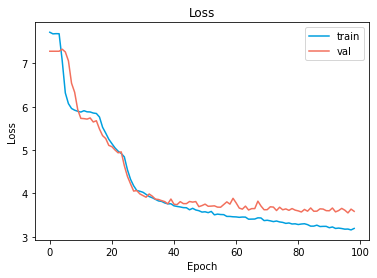

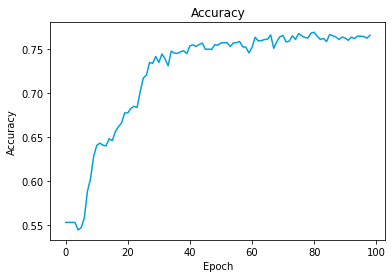

In [121]:
plot_loss(model_file_path)
plot_accuracy(model_file_path, 99)

Plot extra analysis for certain cuts of delta events

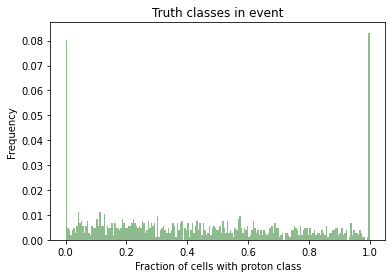

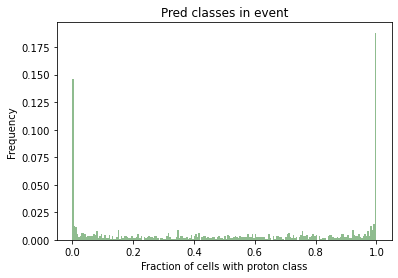

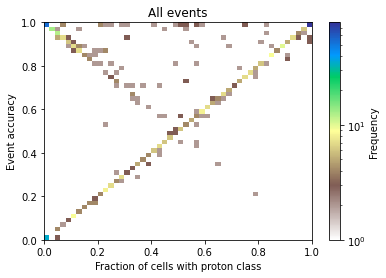

/tmp/ipykernel_42666/3781182081.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  focused_frac = np.array(flatten_one_layer(np.array(processed_event_data["E_frac_focused"])[cut]))


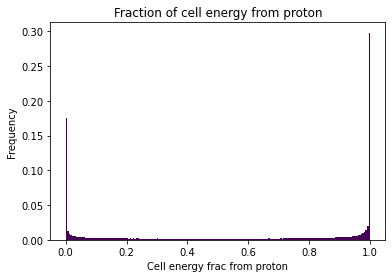

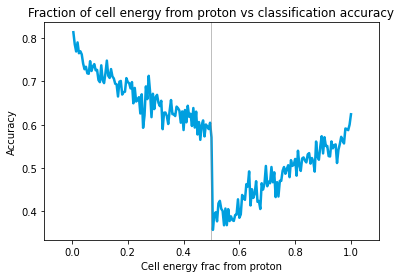

In [122]:
part_of_interest = "proton" # for plot titles (charged particle - proton/pi+/-)

# if delta one track select cut a or b
# a) delta -> pi+/- + neutron
cut_events = (np.array(processed_event_data["decay_group"]) == decay_group["delta-"]) | (np.array(processed_event_data["decay_group"]) == decay_group["delta+_n"])

# b) delta -> pi0 + proton
## cut_events = (np.array(processed_event_data["decay_group"]) == decay_group["delta+_p"])

# if delta two tracks select all events
## cut_events = (np.array(processed_event_data["decay_group"]) == decay_group["delta++"]) | (np.array(processed_event_data["decay_group"]) == decay_group["delta0_p"])


num_bins = 50
plot_frac_events_with_track_of_interest_vs_acc(preds_unmasked, labels_unmasked, part_of_interest, cut_events, num_bins)

num_bins = 200
plot_accuracy_over_cell_energy_frac_from_focused_part(preds_unmasked, labels_unmasked, cut_events, num_bins, get_accuracy_multi_class, part_of_interest)


delta R analysis

In [123]:
# compute delta R between particles
for feat in ["trackP", "trackEta", "trackPhi", "truthPartE", "truthPartPt", "truthPartEta", "truthPartPhi"]:
    processed_event_data[feat] = ak.Array(processed_event_data[feat])

def measure_deltaR(phi1, eta1, p1, phi2, eta2, p2):
    vectors1 = vector.obj(eta=eta1, phi=phi1, rho=p1)
    vectors2 = vector.obj(eta=eta2, phi=phi2, rho=p2)

    return np.array(vectors1.deltaR(vectors2))

charged_part_eta = processed_event_data["truthPartEta"][:, 1]
neutral_part_eta = processed_event_data["truthPartEta"][:, 2]

charged_part_phi = processed_event_data["truthPartPhi"][:, 1]
neutral_part_phi = processed_event_data["truthPartPhi"][:, 2]

charged_part_p = processed_event_data["truthPartPt"][:, 1]
neutral_part_p = processed_event_data["truthPartPt"][:, 2]

deltaR_parts = np.array(measure_deltaR(charged_part_phi, charged_part_eta, charged_part_p, neutral_part_phi, neutral_part_eta, neutral_part_p))

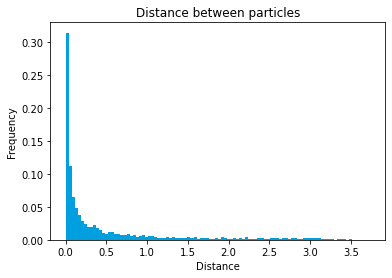

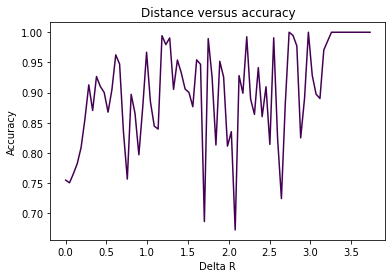

In [124]:
## cut_events = (np.array(processed_event_data["decay_group"]) == decay_group["delta++"]) | (np.array(processed_event_data["decay_group"]) == decay_group["delta0_p"])
## cut_events = (np.array(processed_event_data["decay_group"]) == decay_group["delta+_p"])
## cut_events = (np.array(processed_event_data["decay_group"]) == decay_group["delta+_n"]) #| (np.array(processed_event_data["decay_group"]) == decay_group["delta-"]) | (np.array(processed_event_data["decay_group"]) == decay_group["delta+_p"])

cut_events = (np.array(processed_event_data["decay_group"]) == decay_group["delta-"]) | (np.array(processed_event_data["decay_group"]) == decay_group["delta+_p"])


cut_delta_R = 4
cut = cut_events & (deltaR_parts < cut_delta_R)

bins = 100
plot_hist(deltaR_parts[cut], bins, "Distance between particles", "Distance", "Frequency", colour="#009fdf")#, xlim=(None, 3.5))
plot_accuracy_over_cut(preds_unmasked, labels_unmasked, deltaR_parts, cut, bins, "Distance versus accuracy", "Delta R", get_cut_accuracy )

Plot event displays

event idx: 0
event acc: 0.9402985074626866
delta R: 0.08814607872053876


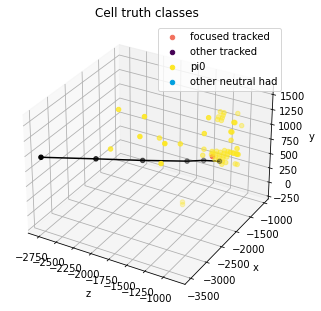

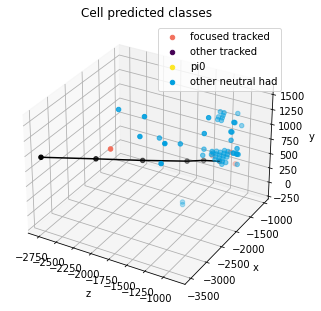

event idx: 1
event acc: 1.0
delta R: 2.9088279485748174


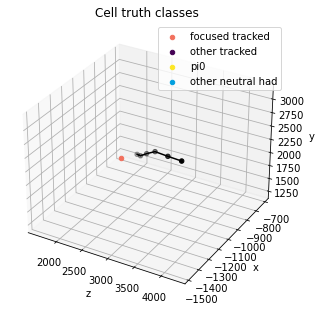

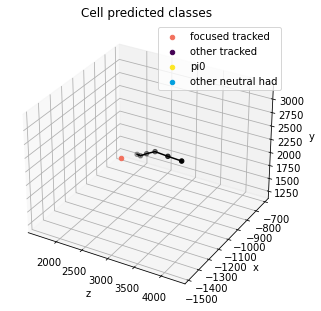

event idx: 2
event acc: 0.5639097744360902
delta R: 0.1352753927242449


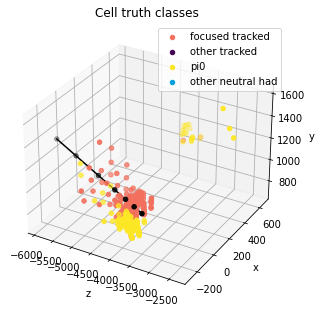

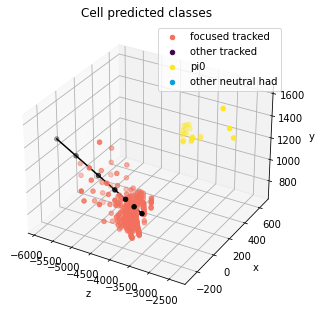

event idx: 3
event acc: 1.0
delta R: 1.1101220778111351


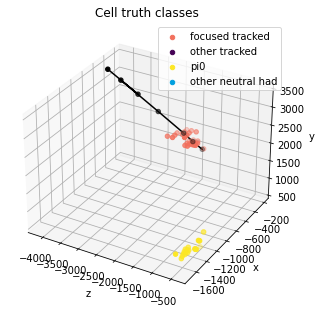

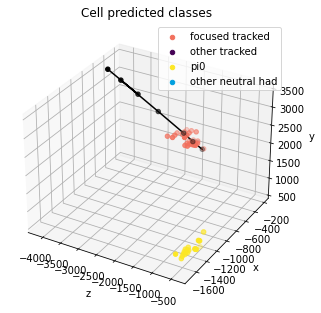

event idx: 4
event acc: 0.9584775086505191
delta R: 0.015955836323811725


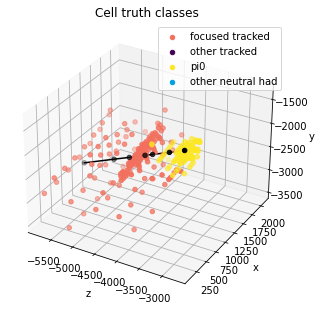

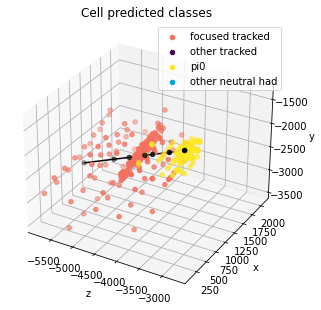

In [125]:
# PREDS VS TRUTH EVENT DISPLAYS

plt.rcParams.update({'font.size': 10})

for event_idx in range(5):
    print("event idx:", event_idx)
    print("event acc:", get_accuracy_multi_class(preds_unmasked[event_idx][np.any(labels_unmasked[event_idx] != -1, axis=1)], labels_unmasked[event_idx][np.any(labels_unmasked[event_idx] != -1, axis=1)]))
    print("delta R:", deltaR_parts[event_idx])

    # plot truth labels
    plot_event_displays([processed_event_data["x"][event_idx]], [processed_event_data["y"][event_idx]], [processed_event_data["z"][event_idx]], [processed_event_data["cell_part_deposit_labels"][event_idx]], ["Cell truth classes"], "z", "x", "y", None, None, [None], [None], [False], event_idx, add_track=True)

    # plot predictions
    event_preds = np.argmax(preds_unmasked[event_idx][np.any(labels_unmasked[event_idx] != -1, axis=1)], axis=1)
    plot_event_displays([processed_event_data["x"][event_idx]], [processed_event_data["y"][event_idx]], [processed_event_data["z"][event_idx]], [event_preds], ["Cell predicted classes"], "z", "x", "y", None, None, [None], [None], [False], event_idx, add_track=True)

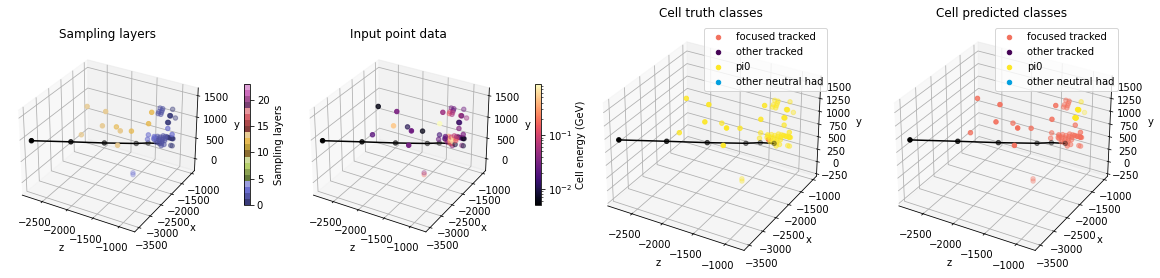

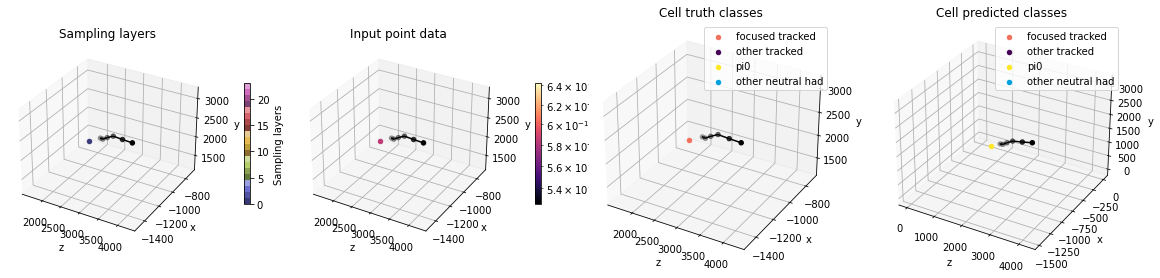

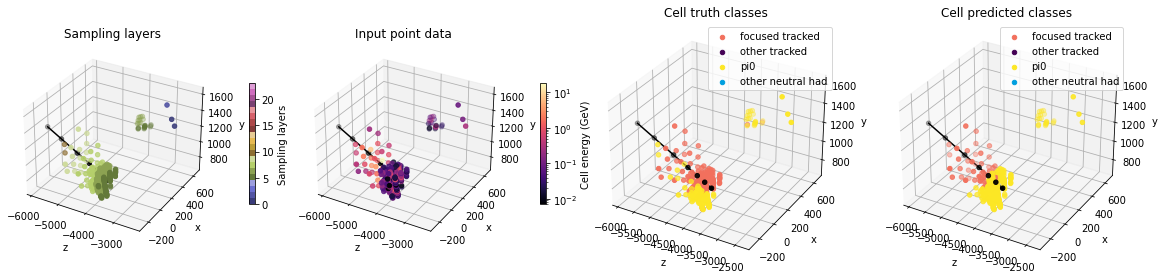

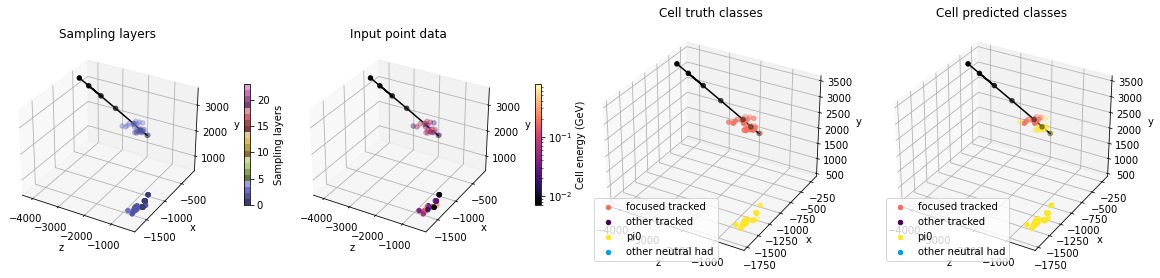

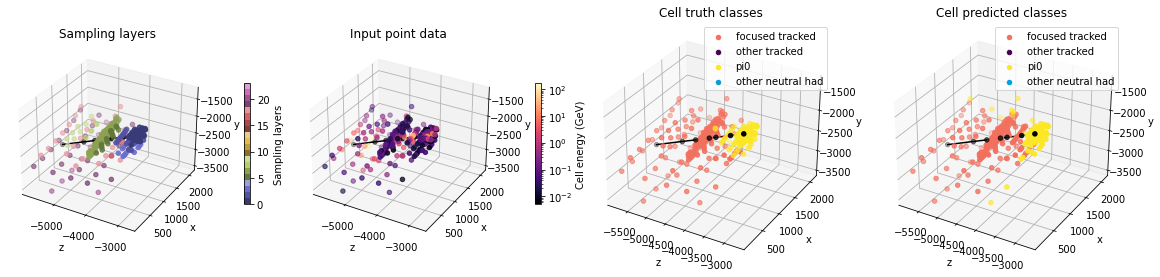

In [101]:
# ADDITIONAL INFO EVENT DISPLAYS
for event_idx in range(5):
    event_preds = np.argmax(preds_unmasked[event_idx][np.any(labels_unmasked[event_idx] != -1, axis=1)], axis=1)
    
    plot_event_displays_inline(event_idx, event_preds)

Testing weighted accuracy

In [110]:
# reformat cell weights and compute cell weights for unweighted eventwise accuracy
processed_event_data["cell_weights"] = np.array(processed_event_data["cell_weights"])
processed_event_data["cell_weights_for_eq_events"] = np.array([np.ones(len(event_cell_energies)) / len(event_cell_energies) for event_cell_energies in processed_event_data["cell_E"]])

/tmp/ipykernel_42666/2361893626.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  processed_event_data["cell_weights_for_eq_events"] = np.array([np.ones(len(event_cell_energies)) / len(event_cell_energies) for event_cell_energies in processed_event_data["cell_E"]])


In [127]:
# PRINT DIFFERENT DEFINITIONS OF ACCURACIES
digits_to_round = 4

print("cut is", str(round(np.count_nonzero(cut_events)/len(cut_events)*100, digits_to_round)) + "% of dataset")
print("Overall accuracy:", round(get_accuracy_multi_class(preds, labels)*100, digits_to_round))
print("(weighted)Overall accuracy:", round(get_weighted_accuracy_multi_class(preds_unmasked, labels_unmasked, np.full(len(processed_event_data["cell_E"]), True))*100, digits_to_round))
print("(Eventwise)Overall accuracy:", round(get_events_weighted_equally_accuracy_multi_class(preds_unmasked, labels_unmasked, np.full(len(processed_event_data["cell_E"]), True))*100, digits_to_round))
print()
print("Accuracy at cut:", round(get_cut_accuracy(preds_unmasked, labels_unmasked, cut_events)*100, digits_to_round))
print("(weighted)Overall accuracy at cut:", round(get_weighted_accuracy_multi_class(preds_unmasked, labels_unmasked, cut_events)*100, digits_to_round))
print("(Eventwise)Overall accuracy at cut:", round(get_events_weighted_equally_accuracy_multi_class(preds_unmasked, labels_unmasked, cut_events)*100, digits_to_round))


cut is 93.525% of dataset
Overall accuracy: 76.2821
(weighted)Overall accuracy: 55.7655
(Eventwise)Overall accuracy: 54.406

Accuracy at cut: 56.6642
(weighted)Overall accuracy at cut: 57.6888
(Eventwise)Overall accuracy at cut: 56.686


Investigate weighted loss (unfinished analysis)

In [126]:
# TODO: fix up plotting weighted loss

def plot_weighted_loss(preds, labels):
    weighted_loss = []
    for epoch_preds in preds:
        weighted_loss.append(get_weighted_loss(epoch_preds, labels))
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(weighted_loss, color="#009fdf")
    plt.xlabel("Epoch")
    plt.ylabel("Weighted loss")
    plt.title("Weighted loss")
    plt.show()

def get_weighted_loss(preds_unmasked, labels_unmasked, cut=None):
    print("get weighted loss")
    labels = labels_unmasked[cut][labels_unmasked[:,:,0][cut] != -1]
    weights = labels_unmasked[cut][labels_unmasked[:,:,1][cut] != -1]
    preds = preds_unmasked[cut][labels_unmasked[:,:,0][cut] != -1]

    print("labels", labels.shape)
    print("weights", weights.shape)
    print("preds", preds.shape)

    num_events = np.count_nonzero(cut)
    #cell_weights = np.array(flatten_one_layer(processed_event_data["cell_weights"][cut]))
    epsilon = 1e-18
    
    bce_loss = (labels * np.log(preds + epsilon) + (1 - labels) * np.log(1 - preds + epsilon))

    return np.sum(bce_loss*weights)/num_events


list_preds_unmasked = []
for epoch in range(5):
    print("start load epoch")
    preds_unmasked = ak.Array(np.load(model_file_path + "/tests/preds_" + str(epoch) + ".npy", allow_pickle=True))
    print("end load epoch")
    list_preds_unmasked.append(preds_unmasked)

plot_weighted_loss(list_preds_unmasked, labels_unmasked)


start load epoch
end load epoch
start load epoch
end load epoch
start load epoch
end load epoch
start load epoch
end load epoch
start load epoch
end load epoch
get weighted loss


AttributeError: no field named 'shape'

(https://github.com/scikit-hep/awkward-1.0/blob/1.8.0/src/awkward/highlevel.py#L1124)

In [ ]:
# TODO: fix up getting weighted loss (unfinished)
print("get weighted loss")
labels = labels_unmasked[labels_unmasked[:,:,0] != -1][:,:4]
weights = labels_unmasked[labels_unmasked[:,:,0] != -1][:,4]
preds = preds_unmasked[labels_unmasked[:,:,0] != -1]

print("labels", len(labels))
print("weights", len(weights))
print("preds", len(preds))

num_events = len(labels_unmasked)
#cell_weights = np.array(flatten_one_layer(processed_event_data["cell_weights"][cut]))
epsilon = 1e-18

bce_loss = -np.sum(labels * np.log(preds + epsilon), axis=1)


# update labels to select one class?? update weights to tile for each cell??
loss = np.sum(bce_loss*weights)/num_events

print("loss:", loss)

get weighted loss


ValueError: in NumpyArray attempting to get 4, index out of range

(https://github.com/scikit-hep/awkward-1.0/blob/1.8.0/src/libawkward/array/NumpyArray.cpp#L4109)

In [ ]:
# get loss with keras (unfinished)
import keras.backend as K

y_true = labels_unmasked
y_pred = preds_unmasked
num_classes = 4


# compute with keras loss
cell_weights = y_true[:, :, num_classes] # the fifth element of every cells class labels is the weight
y_true = y_true[:, :, :num_classes] # cut y_true to only be the 4 classes
cell_ce = K.categorical_crossentropy(y_pred, y_true, axis=2)
print(K.sum(cell_ce * cell_weights, axis=None) / K.sum(cell_weights, axis=None))

ValueError: in NumpyArray attempting to get 4, index out of range

(https://github.com/scikit-hep/awkward-1.0/blob/1.8.0/src/libawkward/array/NumpyArray.cpp#L4109)

In [ ]:
# remove weights from labels
labels_unmasked = labels_unmasked[:,:,:-2]

Varying neutral deposit labels analysis (updated and not tested)

In [ ]:
# reclassify neutrons as pi0 for 1 class of neutral labels analysis
preds_unmasked = np.array(preds_unmasked)
labels_unmasked = np.array(labels_unmasked)

preds_unmasked[:, :, 2] = np.maximum(preds_unmasked[:, :, 2], preds_unmasked[:, :, 3])
preds_unmasked[:, :, 3] = 0
labels_unmasked[:, :, 2] = labels_unmasked[:, :, 2] + labels_unmasked[:, :, 3]
labels_unmasked[:, :, 3] = 0

In [ ]:
# TODO: determine when used and move
both_neutral_classes = []
other_tracked_part = []
for i, event_preds in enumerate(preds_unmasked):
    preds = event_preds[labels_unmasked[i][:,0] != -1]
    pred_class = np.argmax(preds, axis=1)

    both_neutral_classes.append(np.count_nonzero(pred_class == 2) and np.count_nonzero(pred_class == 3))
    
    other_tracked_part.append(np.count_nonzero(pred_class == 1))

print("percent with both neutral classified:", np.count_nonzero(both_neutral_classes)/len(both_neutral_classes))
print("percent with other tracked classified:", np.count_nonzero(other_tracked_part)/len(other_tracked_part))
    

#eye = np.eye(4)
#print(preds_unmasked[0])
#print([np.zeros(4) if np.count_nonzero(preds) == 0 else (np.zeros(4) + eye[np.argmax(cell_preds)]) for cell_preds in preds_unmasked[0]])

#preds_unmasked = [ [np.zeros(4) if np.count_nonzero(preds) == 0 else (np.zeros(4) + eye[np.argmax(cell_preds)]) for cell_preds in event_preds] for event_preds in preds_unmasked[0]]

preds_unmasked = ak.Array(preds_unmasked)
labels_unmasked = ak.Array(labels_unmasked)



summed_event_preds = [np.sum(event_pred, axis=0) for event_pred in preds_unmasked]
more_than_2_classes = [summed_event_pred[2] > 0 and summed_event_pred[3] > 0 for summed_event_pred in summed_event_preds]
print(len(more_than_2_classes))
print(np.count_nonzero(more_than_2_classes))
print("percent of events with more than 2 classes predicted:", np.count_nonzero(more_than_2_classes)/len(more_than_2_classes))


other_track_part_class = [summed_event_pred[1] > 1e-4 for summed_event_pred in summed_event_preds]
print("percent of events with other tracked predicted:", np.count_nonzero(other_track_part_class)/len(other_track_part_class))

PREVIOUSLY USED - TO BE DELETED

In [ ]:
# PREVIOUS HELPER FUNCTIONS
# TODO: add comments to all these functions :(
def get_accuracy(preds, labels):
    correct = (np.array(preds) > 0.5) == np.array(labels)
    return np.count_nonzero(correct)/len(correct)

def get_cut_accuracy(preds_unmasked, labels_unmasked, cut):
    labels = labels_unmasked[cut][labels_unmasked[:,:,0][cut] != -1]
    preds = preds_unmasked[cut][labels_unmasked[:,:,0][cut] != -1]

    return get_accuracy_multi_class(preds, labels)

def get_accuracy_multi_class(preds, labels):
    correct = np.argmax(labels, axis=1) == np.argmax(preds, axis=1)
    return np.count_nonzero(correct)/len(correct)


def get_weighted_accuracy_multi_class(preds_unmasked, labels_unmasked, cut=None):

    labels = labels_unmasked[cut][labels_unmasked[:,:,0][cut] != -1]
    preds = preds_unmasked[cut][labels_unmasked[:,:,0][cut] != -1]

    num_events = np.count_nonzero(cut)
    cell_weights = np.array(flatten_one_layer(processed_event_data["cell_weights"][cut]))
    
    correct = np.argmax(labels, axis=1) == np.argmax(preds, axis=1)

    return np.sum(correct*cell_weights)/num_events

def get_events_weighted_equally_accuracy_multi_class(preds_unmasked, labels_unmasked, cut=None):

    labels = labels_unmasked[cut][labels_unmasked[:,:,0][cut] != -1]
    preds = preds_unmasked[cut][labels_unmasked[:,:,0][cut] != -1]

    num_events = np.count_nonzero(cut)
    cell_weights = np.array(flatten_one_layer(processed_event_data["cell_weights_for_eq_events"][cut]))
    correct = np.argmax(labels, axis=1) == np.argmax(preds, axis=1)

    return np.sum(correct*cell_weights)/num_events


def get_weighted_cut_accuracy(preds_unmasked, labels_unmasked, cut):
    labels = labels_unmasked[cut][labels_unmasked[:,:,0][cut] != -1]
    preds = preds_unmasked[cut][labels_unmasked[:,:,0][cut] != -1]

    return get_weighted_accuracy_multi_class(preds, labels, np.array(processed_event_data["cell_E"])[cut])

# plot train and val loss over epoch
def plot_train_and_val_loss(train_loss, val_loss):
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(train_loss, label="train", color="#009fdf")
    plt.plot(val_loss, label="val", color="#F2705D")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training loss")
    plt.show()

def plot_accuracy(preds, labels):
    accuracy = []
    for epoch_preds in preds:
        accuracy.append(get_accuracy_multi_class(epoch_preds, labels))
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(accuracy, color="#009fdf")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Classification accuracy")
    plt.show()


def plot_accuracy_split_decays(preds, labels, decay_labels):
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    for decay_i, decay_preds in enumerate(preds):
        accuracy = []
        for epoch_decay_preds in decay_preds:
            accuracy.append(get_accuracy_multi_class(epoch_decay_preds, labels[decay_i]))
        plt.plot(accuracy, label=decay_labels[decay_i], color=["mediumorchid", "darkseagreen"][decay_i])
    
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Classification accuracy")
    plt.legend()
    plt.show()
    


def plot_loss_and_accuracy(model_file_path, num_epoch):
    # plot train and val loss
    loss_data = genfromtxt(model_file_path + "/log_loss.csv", delimiter=',').transpose()
    loss = loss_data[1]
    val_loss = loss_data[2]
    plot_train_and_val_loss(loss, val_loss)

    # plot test accuracy
    labels_unmasked = ak.Array(np.load(model_file_path + "/tests/labels.npy"))
    labels = labels_unmasked[labels_unmasked[:,:,0] != -1]
    preds = []

    #cut_delta_p_pi0_events = np.array(processed_event_data["decay_group"]) == decay_group["delta+_p"]
    #cut_delta_n_pipm_events = (np.array(processed_event_data["decay_group"]) == decay_group["delta+_n"]) | (np.array(processed_event_data["decay_group"]) == decay_group["delta-"])
    
    #preds_delta_p_pi0 = []
    #preds_delta_n_pipm = []

    #labels_delta_p_pi0 = labels_unmasked[cut_delta_p_pi0_events][labels_unmasked[:,:,0][cut_delta_p_pi0_events] != -1]
    #labels_delta_n_pipm = labels_unmasked[cut_delta_n_pipm_events][labels_unmasked[:,:,0][cut_delta_n_pipm_events] != -1]

    for epoch in range(num_epoch):
        preds_unmasked = ak.Array(np.load(model_file_path + "/tests/preds_" + str(epoch) + ".npy"))
        epoch_preds = preds_unmasked[labels_unmasked[:,:,0] != -1]
        preds.append(epoch_preds)
        """
        preds_delta_p_pi0.append(preds_unmasked[cut_delta_p_pi0_events][labels_unmasked[:,:,0][cut_delta_p_pi0_events] != -1])
        preds_delta_n_pipm.append(preds_unmasked[cut_delta_n_pipm_events][labels_unmasked[:,:,0][cut_delta_n_pipm_events] != -1])
        """

    plot_accuracy(preds, labels)
    #plot_accuracy_split_decays([preds_delta_p_pi0, preds_delta_n_pipm], [labels_delta_p_pi0, labels_delta_n_pipm], ["delta+ -> p + pi0", "delta+/- -> n + pi+/-"])

# override to test weighted loss
def plot_loss(model_file_path, num_epoch=-1):
    print("call plot loss")
    # plot train and val loss
    loss_data = genfromtxt(model_file_path + "/log_loss.csv", delimiter=',').transpose()
    loss = loss_data[1][:num_epoch]
    val_loss = loss_data[2][:num_epoch]
    plot_train_and_val_loss(loss, val_loss)

    # plot test accuracy
    labels_unmasked = ak.Array(np.load(model_file_path + "/tests/labels.npy", allow_pickle=True))
    print("loaded labels")
    labels = labels_unmasked[labels_unmasked[:,:,0] != -1]
    preds = []

    #cut_delta_p_pi0_events = np.array(processed_event_data["decay_group"]) == decay_group["delta+_p"]
    #cut_delta_n_pipm_events = (np.array(processed_event_data["decay_group"]) == decay_group["delta+_n"]) | (np.array(processed_event_data["decay_group"]) == decay_group["delta-"])
    
    #preds_delta_p_pi0 = []
    #preds_delta_n_pipm = []

    #labels_delta_p_pi0 = labels_unmasked[cut_delta_p_pi0_events][labels_unmasked[:,:,0][cut_delta_p_pi0_events] != -1]
    #labels_delta_n_pipm = labels_unmasked[cut_delta_n_pipm_events][labels_unmasked[:,:,0][cut_delta_n_pipm_events] != -1]
    list_preds_unmasked = []
    for epoch in range(num_epoch):
        print("start load epoch")
        preds_unmasked = ak.Array(np.load(model_file_path + "/tests/preds_" + str(epoch) + ".npy", allow_pickle=True))
        print("end load epoch")
        list_preds_unmasked.append(preds_unmasked)

    plot_weighted_loss(list_preds_unmasked, labels_unmasked)
    #plot_accuracy_split_decays([preds_delta_p_pi0, preds_delta_n_pipm], [labels_delta_p_pi0, labels_delta_n_pipm], ["delta+ -> p + pi0", "delta+/- -> n + pi+/-"])


def plot_frac_events_track_of_interest(preds_unmasked, labels_unmasked, part_of_interest, events_cut, bins):
    track_of_interest_class = 0
    truth_frac_cells_part_of_interest_per_event = np.array([np.count_nonzero(event_decay_group == track_of_interest_class)/len(event_decay_group) for event_decay_group in processed_event_data["cell_part_deposit_labels"]] )
    pred_frac_cells_part_of_interest_per_event = np.array([np.count_nonzero(np.argmax(preds_unmasked[event_i], axis=1)[event_labels_unmasked[:,0] != -1] == track_of_interest_class)/np.count_nonzero(event_labels_unmasked[:,0] != -1) for event_i, event_labels_unmasked in enumerate(labels_unmasked)])
    
    plot_hist(truth_frac_cells_part_of_interest_per_event[events_cut], 200, "Truth classes in event", "Fraction of cells with " + part_of_interest + " class", "Frequency", True, colour="darkseagreen") 
    plot_hist(pred_frac_cells_part_of_interest_per_event[events_cut], 200, "Pred classes in event", "Fraction of cells with " + part_of_interest + " class", "Frequency", True, colour="darkseagreen")

    # plot 2d distribution vs accuracy
    event_mean_acc = np.array([get_accuracy_multi_class(preds_unmasked[event_i][event_labels_unmasked[:, 0] != -1], event_labels_unmasked[event_labels_unmasked[:, 0] != -1]) for event_i, event_labels_unmasked in enumerate(labels_unmasked)])

    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist2d(truth_frac_cells_part_of_interest_per_event[events_cut], event_mean_acc[events_cut], (bins, bins), range=((0,1),(0,1)), cmap=plt.cm.terrain_r, norm=mpl.colors.LogNorm())
    plt.colorbar(label="Frequency")
    plt.xlabel("Fraction of cells with " + part_of_interest + " class")
    plt.ylabel("Event accuracy")
    plt.title("All events")
    plt.show()

def plot_accuracy_over_cell_energy_frac(preds_unmasked, labels_unmasked, cut, num_points, acc_func):

    labels = labels_unmasked[cut][labels_unmasked[:,:,0][cut] != -1]
    preds = preds_unmasked[cut][labels_unmasked[:,:,0][cut] != -1]

    focused_frac = np.array(flatten_one_layer(np.array(processed_event_data["E_frac_focused"])[cut]))

    plot_hist(focused_frac, num_points, "Fraction of cell energy from focused part", "Cell focused part energy frac", "Frequency", colour="#440154FF")

    accuracy = []

    for i in range(num_points):
        E_frac_cut = (focused_frac >= i*(1/num_points)) & (focused_frac < (i+1)*(1/num_points))
        accuracy.append(acc_func(preds[E_frac_cut], labels[E_frac_cut]))
    
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(np.arange(1/num_points, 1 + (1/num_points), 1/num_points), accuracy, color="#009fdf", linewidth=2.5)
    plt.axvline(x=0.5, color='grey', linewidth='0.5')
    plt.xlabel("Cell focused part energy frac")
    plt.ylabel("Accuracy")
    plt.title("Fraction of cell energy from focused part vs classification accuracy")
    plt.xlim((-0.1, 1.1))
    plt.show()

